In [ ]:
TO DO: Update Colab Links
<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_7_neuromorphic_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

: 

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Regression with SNNs: Part II
## Regression-based Classification with Recurrent Leaky Integrate-and-Fire Neurons
## By Alexander Henkes (https://orcid.org/0000-0003-4615-9271) and Jason K. Eshraghian (www.ncg.ucsc.edu)


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_regression_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


This tutorial is based on the following papers on nonlinear regression and spiking neural networks. If you find these resources or code useful in your work, please consider citing the following sources:

> <cite> [Alexander Henkes, Jason K. Eshraghian, and Henning Wessels. “Spiking neural networks for nonlinear regression", arXiv preprint arXiv:2210.03515, October 2022.](https://arxiv.org/abs/2210.03515) </cite>

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

## TO-DO:

* Improve tutorial structure -- would it make more sense to do a Pt 1, Pt 2, Pt 3; and divide them up with "Pt 1: Regression Using Membrane", "Pt 2: Regression with Recurrent LIF Neurons", "Pt 3: Regression with Spiking LSTMs"? That way, people can jump straight to tutorials using RLeaky and SLSTM.
* Update references: include nonlinear regression by a henkes, and Spiking LSTM by Y Yang
* Make the problem statement clear by overlaying the objective function and original membrane potential before training starts
* Start with a LIF-only network, then motivate a Recurrent LIF network, then motivate a Spiking-LSTM
* Add a brief explanation behind the Spiking LSTM. I can draw a computational graph in Visio using a dumbed down explanation of this:  https://www.techrxiv.org/articles/preprint/Neuromorphic_Deep_Spiking_Neural_Networks_for_Seizure_Detection/20444970) 
* (Optional) Use regression to perform a classification task. E.g., apply regression to the membrane potential s.t. it reaches >threshold for the correct class. I've done this quite a lot in the past to good results.

In the regression tutorial series, you will learn how to use snnTorch to perform regression using a variety of spiking neuron models, including:

* Leaky Integrate-and-Fire (LIF) Neurons
* Recurrent LIF Neurons
* Spiking LSTMs

An overview of the regression tutorial series:

* Part I will train the membrane potential of a LIF neuron to follow a given trajectory over time.
* Part II (this tutorial) will use LIF neurons with recurrent feedback to perform classification using regression-based loss functions
* Part III will use a more complex spiking LSTM network instead to train the firing time of a neuron.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
!pip install snntorch --quiet

: 

In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

Fix the random seed:

In [2]:
# Seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# 1. Spiking Regression
## 1.1 A Quick Background on Linear and Nonlinear Regression

The tutorials so far have focused on multi-class classification problems. But if you've made it this far, then it's probably safe to say that your brain can do more than distinguish cats and dogs. You're amazing and we believe in you.

An alternative type of problem neural networks are able to tackle is regression where multiple input features $x_i$ are used to estimate an output on a continuous number line $y \in \mathbb{R}$. 
A classic example is estimating the price of a house, given a bunch of inputs such as land size, number of rooms, and the demand for avocado toast.

The objective of a regression problem is often the mean-square error:

$$\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i-\hat{y_i})^2$$

or the mean absolute error:

$$\mathcal{L}_{L1} = \frac{1}{n}\sum_{i=1}^n|y_i-\hat{y_i}|$$


where $y$ is the target and $\hat{y}$ is the predicted value. 

One of the challenges of linear regression is that it can only use linear weightings of input features in predicting the output. 
Using a neural network trained using the mean-square error as the cost function allows us to perform nonlinear regression on more complex data. 

## 1.2 Spiking Neurons in Regression

Spikes are a type of nonlinearity that can also be used in learning more complex regression tasks. 
But if spiking neurons only emit spikes that are represented with 1's and 0's, then how might we perform regression? I'm glad you asked! Here are a few ideas:

* Use the total number of spikes (a rate-based code)
* Use the time of the spike (a temporal/latency-based code)
* Use the distance between pairs of spikes (i.e., using the interspike interval)

Or perhaps you pierce the neuron membrane with an electrical probe and decide to use the membrane potential instead, which is a continuous value. 

> Note: is it cheating to directly access the membrane potential, i.e., something that is meant to be a 'hidden state'? At this time, there isn't much consensus in the neuromorphic community. The membrane potential is usually a high precision variable as opposed to spike count, or discretized time steps which are often integers, which makes it more 'continuous', and so many research papers resort to applying the membrane potential to the loss function instead. While it costs more in terms of power and latency to operate on higher-precision values, the impact might be minor if you have a small output layer, or if the output does not need to be scaled by weights. It really is a task-specpific and hardware-specific question. 

# 2. Setting up the Regression Problem

## 2.1 Create Dataset

Let's construct a simple toy problem. The following class returns the function we are hoping to learn. If `mode = "linear"`, a straight line with a random slope is generated. If `mode = "sqrt"`, then the square root of this straight line is taken instead. 

Our goal: train a leaky integrate-and-fire neuron such that its membrane potential follows the sample over time. 

In [3]:
class Regression_dataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples
        feature_lst = []

        for idx in range(num_samples):
            end = float(torch.rand(1))
            lin_vec = torch.linspace(start=0.0, end=end, steps=timesteps)
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature)

        self.features = torch.stack(feature_lst, dim=1)

        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)

        else:
            raise NotImplementedError("'linear', 'sqrt'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]


To see what a random sample looks like, run the following code-block:

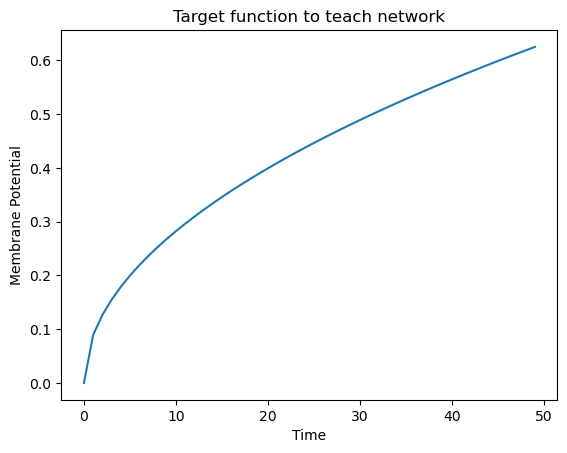

In [25]:
num_steps = 50
num_samples = 1
mode = "sqrt" # 'linear' or 'sqrt'

# generate a single data sample
dataset = Regression_dataset(timesteps=num_steps, num_samples=num_samples, mode=mode)

# plot
sample = dataset.labels[:, 0, 0]
plt.plot(sample)
plt.title("Target function to teach network")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.show()

## 2.2 Create DataLoader

The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [26]:
batch_size = 1

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True)

# 3. Construct Model

Let us try a simple network using only leaky integrate-and-fire layers without recurrence. 
Subsequent tutorials will show how to use more complex neuron types with higher-order recurrence.
These architectures should work just fine, if there is no strong time dependency in the data, i.e., the next time step has weak dependence on the previous one.

A few notes on the architecture below:

* Setting `learn_beta=True` enables the decay rate `beta` to be a learnable parameter
* Each neuron has a unique, and randomly initialized threshold and decay rate
* The output layer has the reset mechanism disabled by setting `reset_mechanism="none"` as we will not use any output spikes

In [34]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden):
        super().__init__()
        
        self.timesteps = timesteps
        self.hidden = hidden
        spike_grad = surrogate.fast_sigmoid()
        
        # randomly initialize decay rate and threshold for layer 1
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=True, spike_grad=spike_grad)
        
        # randomly initialize decay rate and threshold for layer 2
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate for output neuron
        beta_out = torch.rand(1)
        
        # layer 3: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_in = self.lif_in.init_leaky()
        mem_hidden = self.lif_hidden.init_leaky()
        mem_out = self.li_out.init_leaky()

        # Empty lists to record outputs
        cur_out_rec = []
        mem_out_rec = []

        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_in = self.lif_in(cur_in, mem_in)
            
            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_hidden = self.li_out(cur_hidden, mem_hidden)

            cur_out = self.fc_out(spk_hidden)
            _, mem_out = self.li_out(cur_out, mem_out)

            mem_out_rec.append(mem_out)

        return torch.stack(mem_out_rec)

Instantiate the network below:

In [53]:
hidden = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = Net(timesteps=num_steps, hidden=hidden).to(device)


Let's observe the behavior of the output neuron before it has been trained and how it compares to the target function:

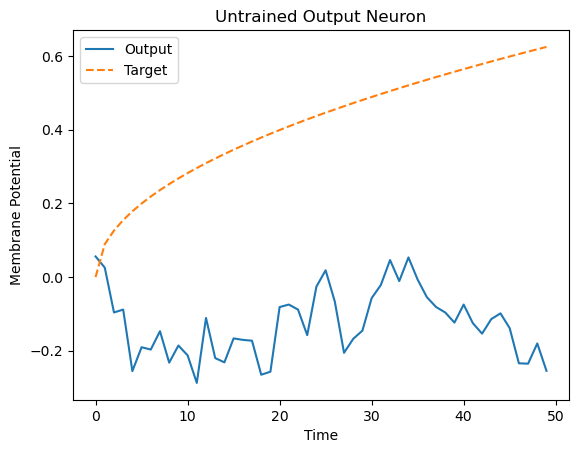

In [54]:
train_batch = iter(dataloader)

with torch.no_grad():
    for feature, label in train_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)
        feature = feature.to(device)
        label = label.to(device)
        mem = model(feature)

# plot
plt.plot(mem[:, 0, 0], label="Output")
plt.plot(label[:, 0, 0], '--', label="Target")
plt.title("Untrained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.legend(loc='best')
plt.show()

As the network has not yet been trained, it is unsurprising the membrane potential follows a senseless evolution.

# 4. Construct Training Loop

We call `torch.nn.MSELoss()` to minimize the mean square error between the membrane potential and the target evolution.

We iterate over the same sample of data.

In [55]:
num_iter = 100

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

loss_hist = []
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)
            mem = model(feature)

            loss_val = loss_function(mem, label)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())

            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)

100%|██████████| 100/100 [00:03<00:00, 25.42it/s, loss=5.774e-04]


# 5. Evaluation

In [56]:
loss_function = torch.nn.L1Loss()
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)

    minibatch_counter = 0
    rel_err_lst = []

    for feature, label in test_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)

        feature = feature.to(device)
        label = label.to(device)

        mem = model(feature)

        rel_err = torch.linalg.norm(
            (mem - label), dim=-1
        ) / torch.linalg.norm(label, dim=-1)
        rel_err = torch.mean(rel_err[1:, :])

        loss_val = loss_function(mem, label)

        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())

        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")
print(f"{'Mean rel. err.:':<{20}}{mean_rel:1.2e}")

Mean L1-loss:       8.55e-03
Mean rel. err.:     6.02e-02


Let's plot our results for some visual intuition:

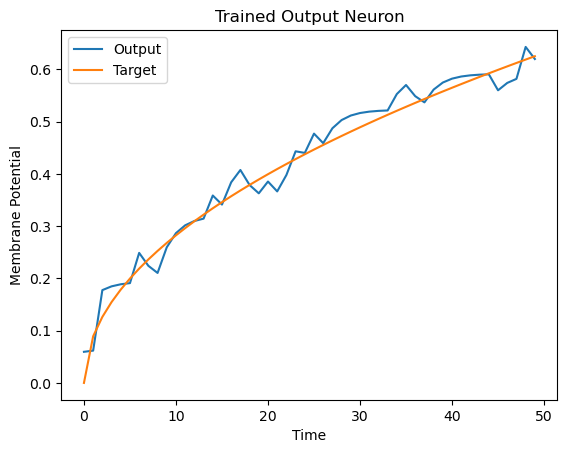

In [60]:
mem = mem.cpu()
label = label.cpu()

plt.title("Trained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
for i in range(batch_size):
    plt.plot(mem[:, i, :], label="Output")
    plt.plot(label[:, i, :], label="Target")
plt.legend(loc='best')
plt.show()

It is a little jagged, but it's not looking too bad. 

You might try to improve the curve fit by expanding the size of the hidden layer, increasing the number of iterations, adding extra time steps, hyperparameter fine-tuning, or using a completely different neuron type.

# Conclusion

The next regression tutorials will test more powerful spiking neurons, such as Reucrrent LIF neurons and spiking LSTMs, to see how they compare.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* More detail on nonlinear regression with SNNs can be found in our corresponding preprint here: [Henkes, A.; Eshraghian, J. K.; and Wessels, H.  “Spiking neural networks for nonlinear regression", arXiv preprint arXiv:2210.03515, Oct. 2022.](https://arxiv.org/abs/2210.03515) 

## NOTES: The following neurons can go into separate tutorials.

## RLIF for classification?

## SLSTM for spike time loss? 

## SConvLSTM to draw a picture?

# RLIF

For short-time dependencies, reccurence can be introduced in the LIF, resulting in an RLIF. Typically, time series with dependencies up to around ten timesteps can be well captured by standard recurrent neurons.

In [ ]:
#TODO

# SLSTM

For long-time dependencies, some sort of "memory" has to be introduced in our architecture. One of the most common and succesfull approaches towards time series with long dependencies was introduced in the 1990th and is called "Long-short-term memory" [...]. By introducing a memory ..... (architecture, pictures etc.)

In [57]:
class SLSTM(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden

        # spike_grad = snntorch.surrogate.atan() --> Not in the current version
        spike_grad = snntorch.surrogate.fast_sigmoid()
        
        thr_lstm_1 = torch.rand(self.hidden)

        self.slstm_1 = snntorch.SLSTM(
            input_size=1,
            hidden_size=self.hidden,
            spike_grad=spike_grad,
            learn_threshold=True,
            threshold=thr_lstm_1,
            reset_mechanism="none",
        )

        beta_out = torch.rand(1)
        thr_out = torch.rand(1)

        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(
            beta=beta_out,
            threshold=thr_out,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=spike_grad,
            reset_mechanism="none",
        )

    def forward(self, x):
        """Forward pass for several time steps."""
        mem_in = self.lif.init_leaky()
        syn_lstm_1, mem_lstm_1 = self.slstm_1.init_slstm()
        mem_out = self.li.init_leaky()

        cur_out_rec = []
        mem_out_rec = []
        spk_out_rec = []

        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            spk_in = x_timestep
            spk_lstm_1, syn_lstm_1, mem_lstm_1 = self.slstm_1(
                spk_in, syn_lstm_1, mem_lstm_1
            )
            cur_out = self.fc_out(mem_lstm_1)
            cur_out, mem_out = self.li_out(cur_out, mem_out)

            cur_out_rec.append(cur_out)
            mem_out_rec.append(mem_out)
            spk_out_rec.append(spk_in)

        return (
            torch.stack(cur_out_rec, dim=0),
            torch.stack(mem_out_rec, dim=0),
            torch.stack(spk_out_rec, dim=0),
        )

# Introduction

Different strategies for regression


1.   **Membrane potential**: ...

2.   **The other thing**: ...

In this tutorial, we will assume we have some non-spiking input data (i.e., the MNIST dataset) and that we want to encode it into spikes using a few different techniques. So let's get started! 

Install the latest PyPi distribution of snnTorch:

In [51]:
!pip install snntorch

## 2. Model



In [58]:
model = SNN(timesteps=TIMESTEPS, hidden=HIDDEN).to(DEVICE)

## 3. Training

In [59]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.MSELoss()

loss_hist = []
with tqdm.trange(ITER) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(DEVICE)
            label = label.to(DEVICE)
            cur, mem, spk = model(feature)
            # spk_lst.append(spk.detach().cpu())

            loss_val = loss_function(mem, label)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())

            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.00it/s, loss=8.466e-08]


## 4. Evaluation

In [60]:
loss_function = torch.nn.L1Loss()
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)

    minibatch_counter = 0
    rel_err_lst = []

    for feature, label in test_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)

        feature = feature.to(DEVICE)
        label = label.to(DEVICE)

        cur, mem, spk = model(feature)

        rel_err = torch.linalg.norm(
            (mem - label), dim=-1
        ) / torch.linalg.norm(label, dim=-1)
        rel_err = torch.mean(rel_err[1:, :])

        loss_val = loss_function(mem, label)

        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())

        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")
print(f"{'Mean rel. err.:':<{20}}{mean_rel:1.2e}")


Mean L1-loss:       1.70e-03
Mean rel. err.:     4.62e-04


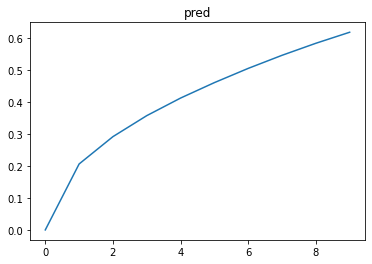

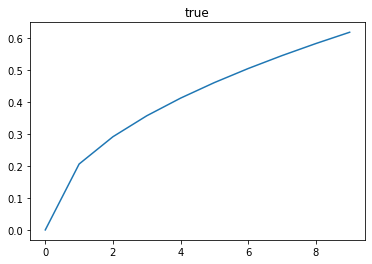

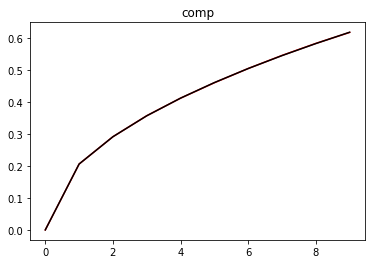

In [61]:
mem = mem.cpu()
label = label.cpu()
plt.figure(1)
plt.title("pred")
for i in range(BATCH_SIZE):
    plt.plot(mem[:, i, :])

plt.figure(2)
plt.title("true")
for i in range(BATCH_SIZE):
    plt.plot(label[:, i, :])

plt.figure(3)
plt.title("comp")
for i in range(BATCH_SIZE):
    plt.plot(mem[:, i, :], color="red")
    plt.plot(label[:, i, :], color="black")
plt.show()